In [2]:

pip install timeit

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement timeit (from versions: none)
ERROR: No matching distribution found for timeit


In [2]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import plotly.graph_objects as go
import matplotlib.pylab as plt
from astropy.time import Time
from timeit import default_timer

# print(f"{np.__name__} --> version {np.__version__}")
# print(f"{pa.__name__} --> version {pa.__version__}")
!python -c "import numpy as xx; print(f'{xx.__name__} \t--> version {xx.__version__}')"
!python -c "import pyarrow as xx; print(f'{xx.__name__} --> version {xx.__version__}')"
!python -c "import plotly as xx; print(f'{xx.__name__} \t--> version {xx.__version__}')"
!python -c "import astropy as xx; print(f'{xx.__name__} --> version {xx.__version__}')"


numpy 	--> version 1.22.4
pyarrow --> version 9.0.0
plotly 	--> version 5.10.0
astropy --> version 5.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Universidad/Trabajo de Titulo/Modelos ML curvas de luz

# %cd /content/drive/MyDrive/Universidad/Trabajo de Titulo/Modelos ML curvas de luz#Aca va tu ruta del archivo en tu drive

ModuleNotFoundError: No module named 'google.colab'

In [3]:
parquet_file = pq.ParquetFile('../lightcurves_ts.parquet')
# parquet_file.schema_arrow.names # obtienes nombre columnas
# parquet_file.metadata.num_rows # numero de filas
# parquet_file.metadata.num_columns # nummero de columnas 

print("numero de columnas:", parquet_file.metadata.num_columns)
print("numero de filas (datos): ", parquet_file.metadata.num_rows)

numero de columnas: 113
numero de filas (datos):  13844917


In [4]:
# Descipcion de las columnas
# oid -- object id
# fid -- filter id, filtro o banda utilizada (verde,rojo,azul,etc)
# mjd -- medida de tiempo continua (Modified Julian date / Calendario Juliano Modificado)
# magpsf_corr -- magnitud psf correjida / posicion en el espacio, es el promedio de los pixeles de una deteccion
# sigmapsf_corr -- variacion de los pixeles de una deteccion
# nbad -- numero de bandas
# classALeRCE - clasificación que realiza ALeRCE en base a los parametros obtenidos (152 aprox) con el random forest de 2 niveles

# se divide el paquete en grupos --> se ocupa el primer grupo 0
data = parquet_file.read_row_group(0, ['oid', 'fid', 'mjd', 'magpsf_corr', 'sigmapsf_corr', 'nbad', 'classALeRCE']).to_pandas()
# data.shape
# data.head(50)

In [56]:
data.shape
data.head()

,oid,fid,mjd,magpsf_corr,sigmapsf_corr,nbad,classALeRCE
0,ZTF17aaacfxu,1,58863.138021,20.996371,0.444790,0,RRL
1,ZTF17aaacfxu,1,58867.179803,19.374605,0.175861,0,RRL
2,ZTF17aaacfxu,1,58871.170336,19.630466,0.123111,0,RRL
3,ZTF17aaacfxu,1,58880.146204,19.362001,0.103466,0,RRL
4,ZTF17aaacfxu,1,58849.131389,19.530453,0.078387,0,RRL


In [5]:
# muestra los eventos unicos, sin repeticiones
all_event = data.oid.unique()
# all_event

print('eventos totales',all_event.shape)

eventos totales (173693,)


In [6]:
data.oid.unique()

array(['ZTF17aaacfxu', 'ZTF17aaaczwj', 'ZTF17aaaemke', ...,
       'ZTF20abgdwuf', 'ZTF20abhagts', 'ZTF20abiqqow'], dtype=object)

In [107]:
def getStatistic(index,indBin,magnitud, amount_bins):
    #Analisis en base a la magnitud
    mag_ordered = magnitud[index]

    #Obtención de vectores con caracteristicas estadisticas
    vector_mean = np.array([np.nanmean(
        mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000  for i in range(amount_bins)])
    
    vector_max = np.array([np.nanmax(
        mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000 for i in range(amount_bins)])
    
    vector_min = np.array([np.nanmin(
        mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000 for i in range(amount_bins)])
    
    vector_std = np.array([np.nanstd(
        mag_ordered[indBin==(i+1)])  if (indBin==(i+1)).sum()>0 else -1000 for i in range(amount_bins)])

    return [vector_mean,vector_max,vector_min,vector_std]


def drawGraphic(bins,time,mag,indice,period):
    title_figure = f'Folded Time Serie with period T/{period}'
    #Grafico para ver la serie de tiempo 
    plt.figure(figsize=(12,4))
    plt.plot(time[indice], mag[indice])
    plt.scatter(time[indice], mag[indice])
    plt.ylabel("Magnitud")
    plt.xlabel("Time")
    plt.suptitle(title_figure, fontsize=22)
    plt.grid(axis='x', color='red', linestyle='-', linewidth=2)
    
    for bin in bins:
        plt.axvline(x=bin,color='red')

    # plt.grid(axis='y', color='gray', linestyle='dashed')
    plt.show()


def variantion_period_v2(array_periods,ts_time, ts_mag, amount_bins=10):
    
    tensor_data = []

    for index, period in enumerate(array_periods):

        #valor del periodo en decimales
        period_float = 1 / period

        #proceso de folding
        folded_time = ts_time % period_float

        #indices de los datos para encontrarlos luego del folding
        index_folded = np.argsort(folded_time)

        #Divido el periodo en bins o intervalos [0,n] para luego obtener datos estadisticos de cada bin
        bins = np.linspace(0,period_float,amount_bins+1)

        #Concentración de datos en cada bin
        concentration, bin_edges= np.histogram(folded_time[index_folded],bins=bins)
        
        #indices - Devuelve los índices de los bins a los que pertenece cada valor del folded_time
        index_bin = np.digitize(folded_time[index_folded],bins=bins)

        print("bins: ",bins)
        print("concentracion de datos en cada bin: ",concentration)

        # Visualizar grafico de cada variación del periodo
        drawGraphic(bins,folded_time,ts_mag,index_folded,period)
    
        #Obtención de datos estadisticos de cada bin y formación del tensor
        vectorStatisticPeriod = np.asmatrix(getStatistic(index_folded,index_bin,ts_mag,amount_bins))
        tensor_data.append(vectorStatisticPeriod)

    return tensor_data


# funcion para graficar la serie de tiempo con link al sitio web de ALeRCE del evento
def GraphicLightCurve(fig,band,light_curve,show):
    mtcolor = [['g','green'],['r','red'],['b','blue']]
    idx=(light_curve['fid']==band).values
    fig.add_trace(
            go.Scatter(
                x = light_curve.mjd.values[idx],
                y = light_curve.magpsf_corr.values[idx],
                mode = 'markers', name=mtcolor[band-1][0],
                marker_color = mtcolor[band-1][1],
                error_y = dict(type='data', array=light_curve.sigmapsf_corr.values[idx], visible=True),
                marker = dict(size=10, opacity=0.5, showscale=False, line=dict(width=1)), 
                showlegend = True,
                legendgroup = mtcolor[band-1][0],
                hovertemplate ='<b>' + mtcolor[band-1][0] + ':\t\t</b>' + light_curve.magpsf_corr[idx].map('{:.3f}'.format).apply(str) + ' ± ' +
                                light_curve.sigmapsf_corr[idx].map('{:.3f}'.format).apply(str)  + '<br>' + 
                                '<b>MJD:\t</b>'+ light_curve.mjd[idx].apply(str)  + '<br>' + 
                                '<b>Date:\t</b>'+ [temp.strftime('%a, %d %b %Y %H:%M:%S UTC') for temp in Time(light_curve.mjd[idx].values, format='mjd').datetime]+ '<br>' +
                                '<extra></extra>'
                ))
    # fig['layout']['yaxis']['autorange'] = "reversed"
    fig.update_xaxes(
        tickangle=0,
        title_text="Modified Julian Dates [MJD]",
        title_font={"size": 14})
    
    fig.update_yaxes(
        autorange= 'reversed',
        tickangle=0,
        title_text="Magnitude [Mag]",
        title_font={"size": 14})
    
    fig.update_layout(
        title={'text':'<b>Light Curve</b>' + '<br>' +
                        '<a href="https://alerce.online/object/'+ event + '">Object: ' + event + 'text</a>',
                'font':dict(size=14),'x':0.5, 'y':0.9,'xanchor': 'center','yanchor': 'top'})
    
    if_show_fig = lambda show: fig.show() if show == True else False
    if_show_fig(show)


     

In [11]:
whos

Variable               Type                          Data/Info
--------------------------------------------------------------
GraphicLightCurve      function                      <function GraphicLightCurve at 0x7f23a93a8680>
Time                   ABCMeta                       <class 'astropy.time.core.Time'>
all_event              ndarray                       173693: 173693 elems, type `object`, 1389544 bytes (1.3251724243164062 Mb)
data                   DataFrame                                        oid  f<...>3844917 rows x 7 columns]
default_timer          builtin_function_or_method    <built-in function perf_counter>
drawGraphic            function                      <function drawGraphic at 0x7f23a93a8320>
drive                  module                        <module 'google.colab.dri<...>s/google/colab/drive.py'>
getStatistic           function                      <function getStatistic at 0x7f23a93a8200>
go                     module                        <module 'plotl

In [7]:
# parametros iniciales 
num_periods = 4
nbines = 10
array_periods = 2**(np.arange(num_periods)+0)
print(f'Arreglo de periodos: {array_periods}')

# cantidad de eventos a analizar 
limit = 5

# arreglo que contiene el tiempo de ejecucion de cada evento, posteriormente se obtendra el promedio
all_time_event = []

Arreglo de periodos: [1 2 4 8]


In [ ]:
# tiempo de ejecucion del algoritmo 
start_analyze = default_timer()

# all_data = []

for index, event in enumerate(all_event):
  # inicio - tiempo de ejecucion del analisis de cada evento
  start_time_event = default_timer()
  print(f'n:{index} - oid:{event}')

  # extrae todas las magnitudes asociadas al evento y las ordena por tiempo (mjd)
  light_curve = data.loc[data['oid'] == event].sort_values(by=['mjd'])
  

  # indices asociados a la banda 1 
  idx_banda = light_curve['fid'] == 1
  # light_curve['fid'].head()
  print(light_curve['fid'])
  tiempoNormalizado = (light_curve.mjd.values - light_curve.mjd.values.min())/(light_curve.mjd.values.max()- light_curve.mjd.values.min())
  print('tiempoNormalizado',len(tiempoNormalizado))
  tensor = np.array(variantion_period_v2(array_periods, tiempoNormalizado[idx_banda], light_curve.magpsf_corr[idx_banda].values, nbines))

  # print(f'Tensor {index}: \n{tensor}')
  fig = go.Figure()


  # graficar serie de tiempo con link a sitio de ALeRCE
  for band in light_curve['fid'].unique():
    GraphicLightCurve(fig,band,light_curve,True)
    

  # fin
  end_time_event = default_timer()
  # obtener el tiempo de ejecucion
  time_method_event = end_time_event - start_time_event
  # agrego el tiempo de ejecicion al arreglo para obtener el promedio general
  all_time_event.append(time_method_event)
  # print(f'tiempo de ejecucion por evento: {time_method_event}')
  print('-'*100)

  if (index == limit - 1):
    break


end_analyze = default_timer()
time_method_analyze = end_analyze - start_analyze
print('-'*100)
print(f'tiempo de ejecucion total: {time_method_analyze}')
print(f'promedio de tiempo de ejecucion por evento',np.mean(all_time_event))
print('-'*100)



# Analisis con distintos filtros


In [108]:
# parametros iniciales 
num_periods = 4
nbines = 10
array_periods = 2**(np.arange(num_periods)+0)
print(f'Arreglo de periodos: {array_periods}')

# cantidad de eventos a analizar 
limit = 5

# arreglo que contiene el tiempo de ejecucion de cada evento, posteriormente se obtendra el promedios
all_time_event = []

Arreglo de periodos: [1 2 4 8]


n:0 - oid:ZTF17aaacfxu


bins:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
concentracion de datos en cada bin:  [2 0 0 0 1 1 0 1 0 0]


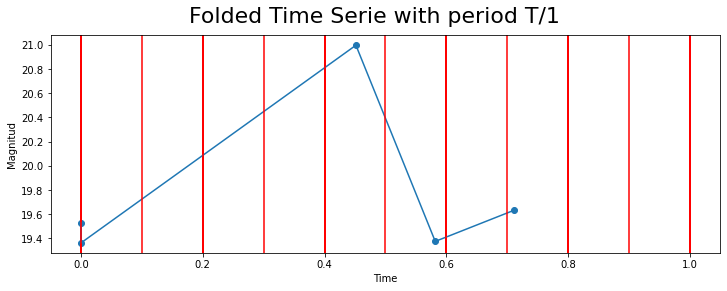

bins:  [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
concentracion de datos en cada bin:  [2 1 0 0 1 0 0 0 0 1]


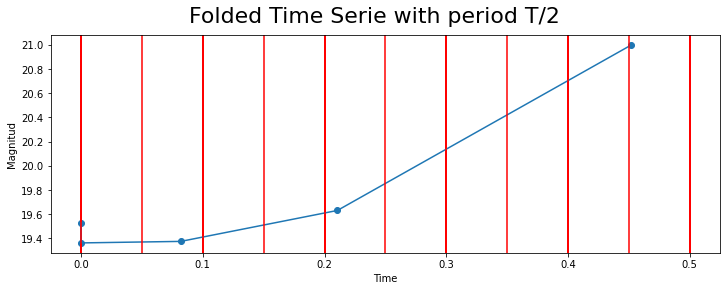

bins:  [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25 ]
concentracion de datos en cada bin:  [2 0 0 1 0 0 0 0 2 0]


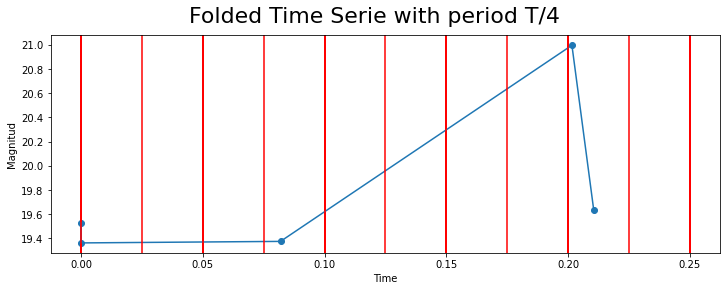

bins:  [0.     0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1    0.1125
 0.125 ]
concentracion de datos en cada bin:  [2 0 0 0 0 0 3 0 0 0]


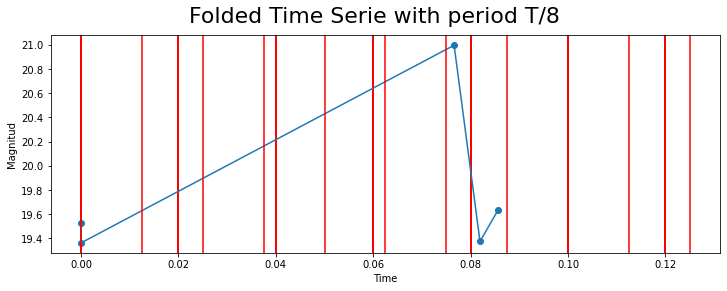

--------------------------------------------------
n:1 - oid:ZTF17aaaczwj


n:2 - oid:ZTF17aaaemke


C:\Users\Leonardo Peña\AppData\Local\Temp\ipykernel_10016\2392262248.py:42: RuntimeWarning:

invalid value encountered in true_divide



bins:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
concentracion de datos en cada bin:  [ 6  3  0  0 12 12  5  0  0  6]


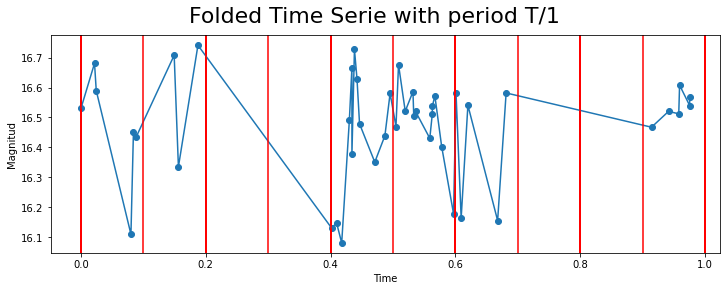

bins:  [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
concentracion de datos en cada bin:  [ 9  9  4  4  0  0  0  0 11  7]


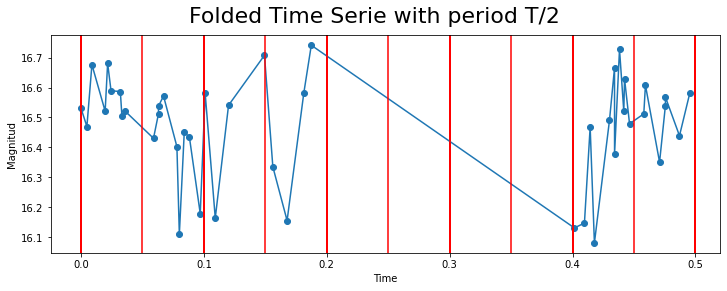

bins:  [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25 ]
concentracion de datos en cada bin:  [6 3 4 5 3 1 6 9 3 4]


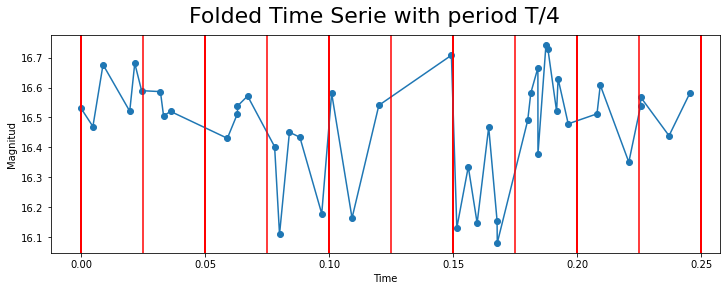

bins:  [0.     0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1    0.1125
 0.125 ]
concentracion de datos en cada bin:  [3 4 6 3 6 7 5 3 5 2]


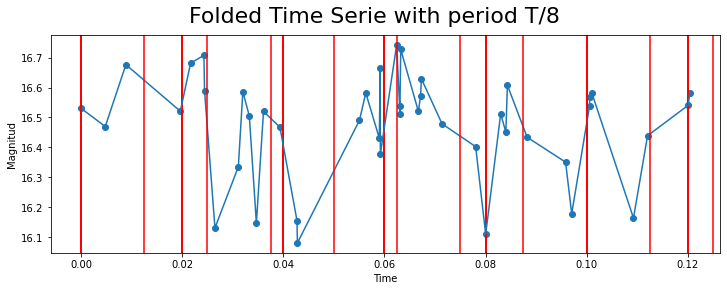

--------------------------------------------------
bins:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
concentracion de datos en cada bin:  [ 4  2  0  2 10  9  4  0  0 13]


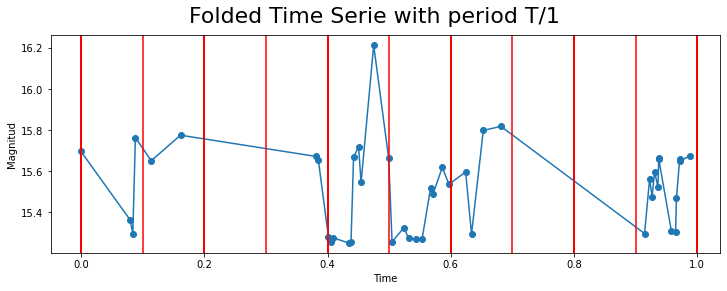

bins:  [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
concentracion de datos en cada bin:  [ 5  8  3  3  0  0  0  2 13 10]


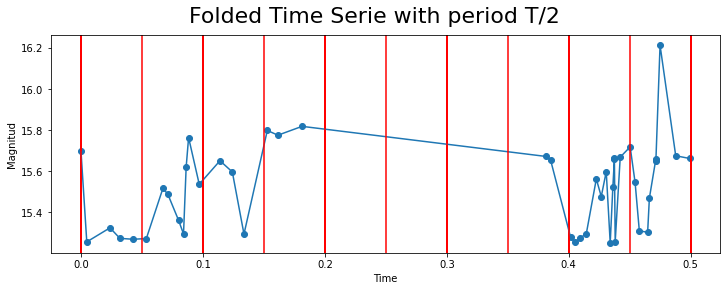

bins:  [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25 ]
concentracion de datos en cada bin:  [3 2 3 5 2 3 7 9 8 2]


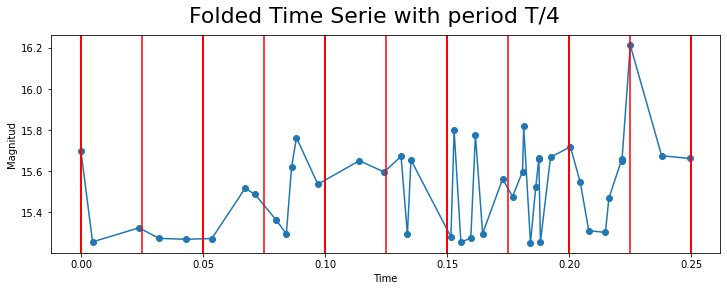

bins:  [0.     0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1    0.1125
 0.125 ]
concentracion de datos en cada bin:  [5 1 6 3 8 4 6 7 0 4]


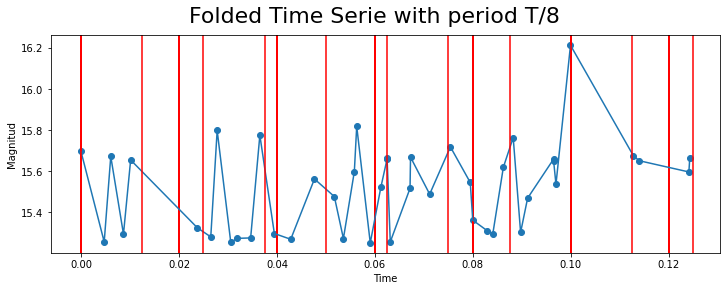

--------------------------------------------------
n:3 - oid:ZTF17aaafyya


bins:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
concentracion de datos en cada bin:  [45 19 12  1 18 30 41  7  1 34]


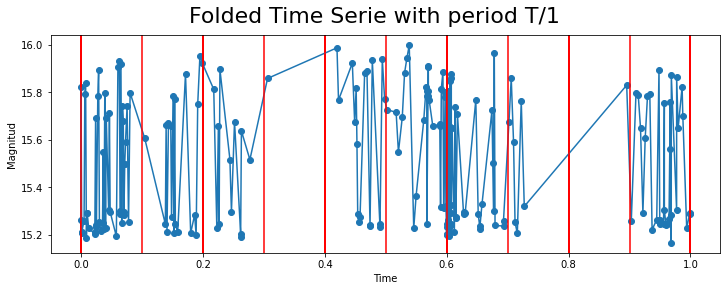

bins:  [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
concentracion de datos en cada bin:  [38 37 37 23 14  5  1  1 17 35]


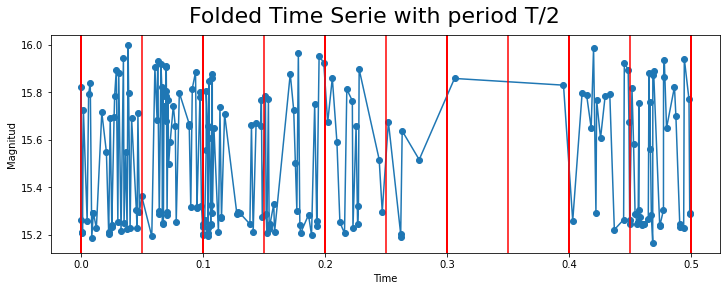

bins:  [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25 ]
concentracion de datos en cada bin:  [21 22 24 14 27 11 18 22 30 19]


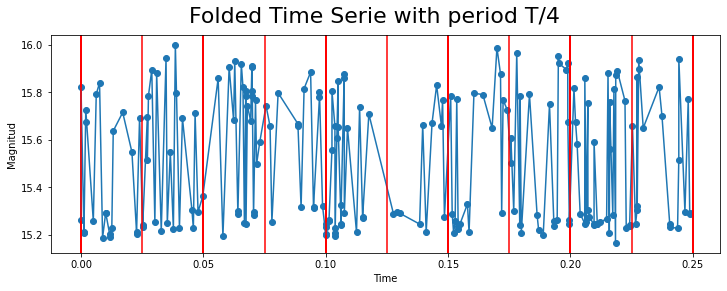

bins:  [0.     0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1    0.1125
 0.125 ]
concentracion de datos en cada bin:  [17 15 23 17 14 32 20 24 32 14]


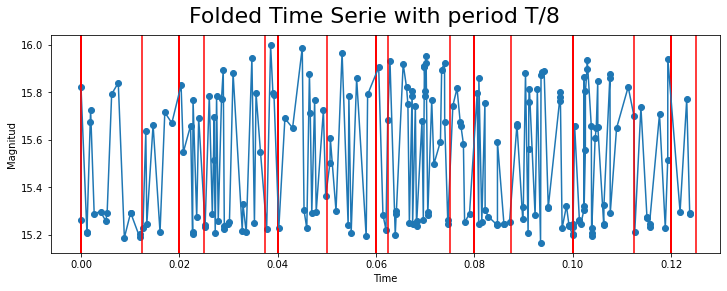

--------------------------------------------------
bins:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
concentracion de datos en cada bin:  [13 21 12  0 11 32 41  8  0 29]


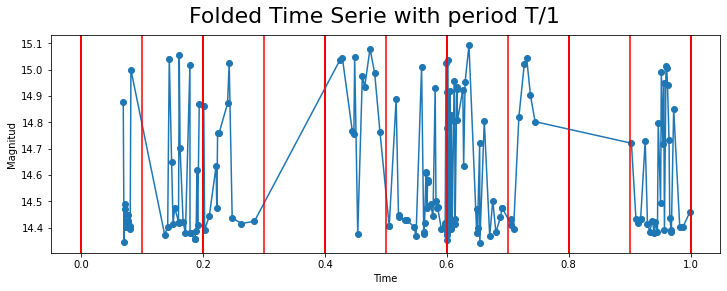

bins:  [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
concentracion de datos en cada bin:  [ 9 36 34 28 18  2  0  0 18 22]


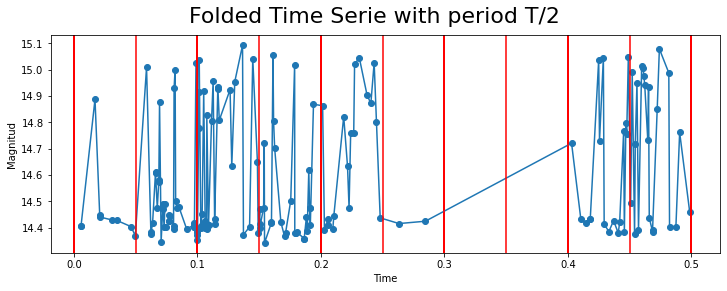

bins:  [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25 ]
concentracion de datos en cada bin:  [ 6  5 17 19 25  9 20 26 27 13]


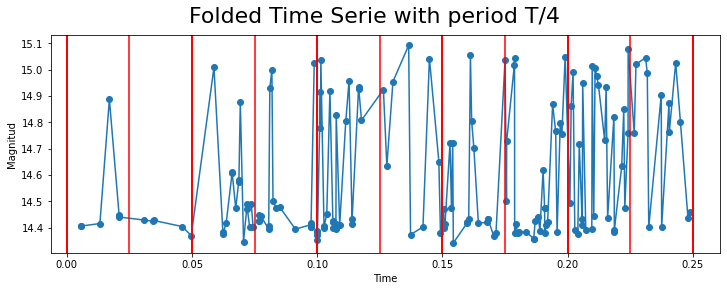

bins:  [0.     0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1    0.1125
 0.125 ]
concentracion de datos en cada bin:  [ 7  8 15 10 15 28 28 18 25 13]


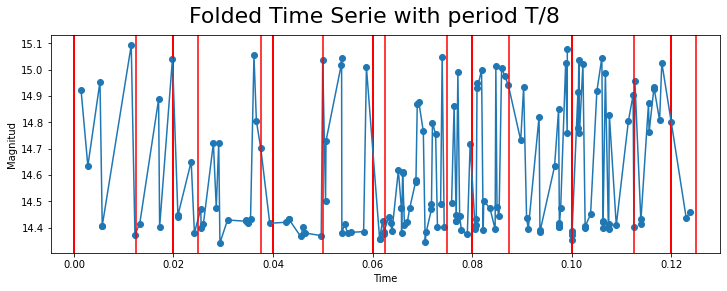

--------------------------------------------------
n:4 - oid:ZTF17aaageae


bins:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
concentracion de datos en cada bin:  [20 10  0  2 27 25 17  1  0 29]


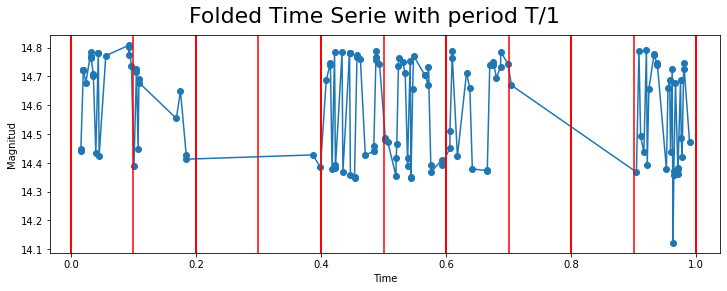

bins:  [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
concentracion de datos en cada bin:  [32 13 14 13  1  0  0  2 24 32]


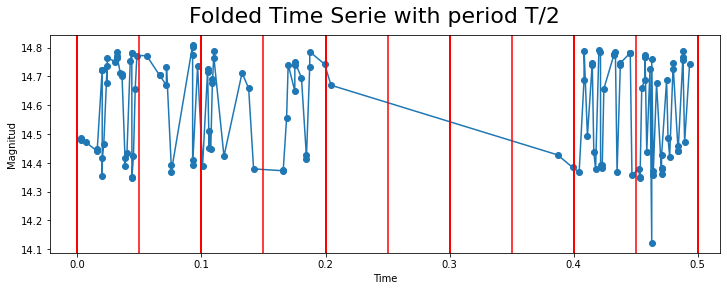

bins:  [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25 ]
concentracion de datos en cada bin:  [14 18  5  8 11  5 18 19 21 12]


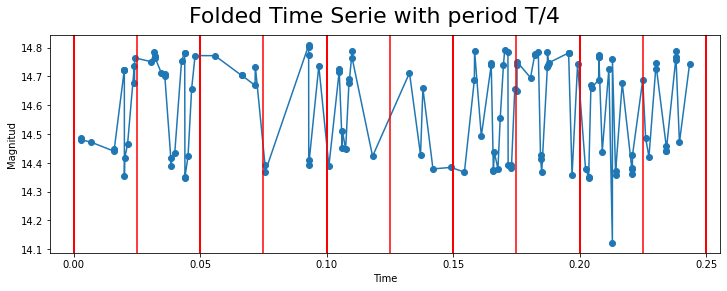

bins:  [0.     0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1    0.1125
 0.125 ]
concentracion de datos en cada bin:  [ 5 14 11 25 13 11 13 16 17  6]


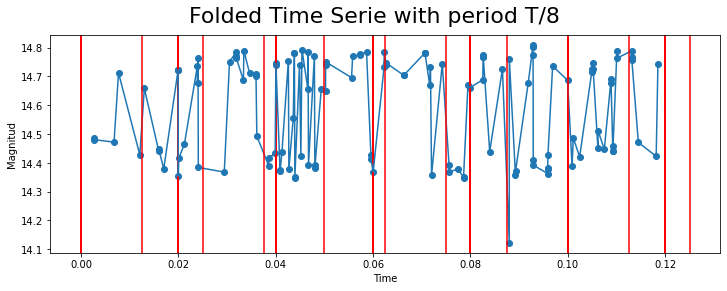

--------------------------------------------------
bins:  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
concentracion de datos en cada bin:  [14 11  0  2 12 13 10  1  1 22]


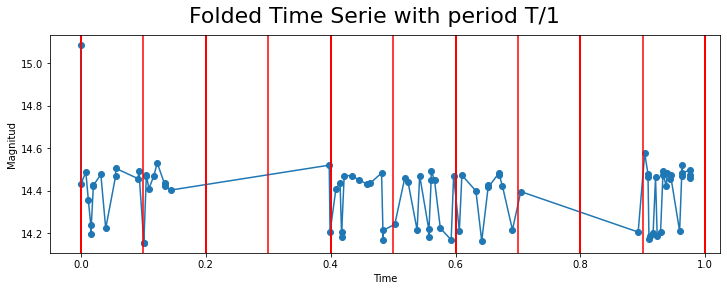

bins:  [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
concentracion de datos en cada bin:  [15 12 15  6  1  0  0  3 22 12]


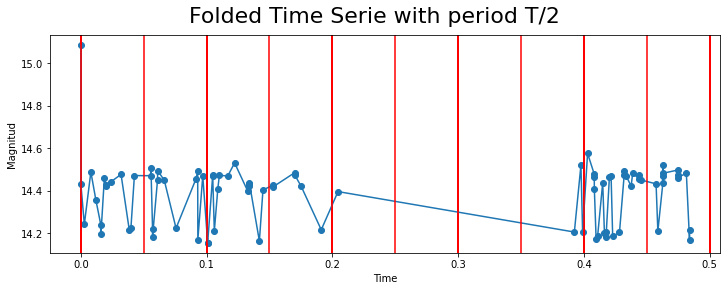

bins:  [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25 ]
concentracion de datos en cada bin:  [11  4  7  5  9  9 17 11 10  3]


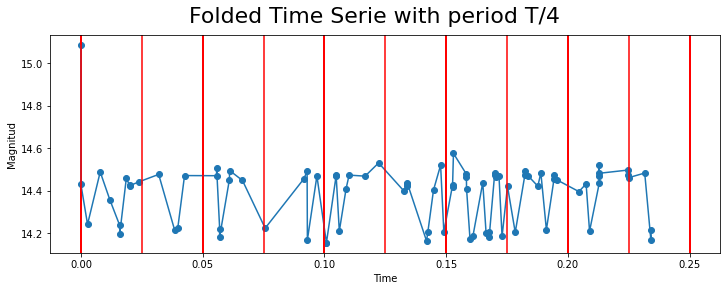

bins:  [0.     0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1    0.1125
 0.125 ]
concentracion de datos en cada bin:  [ 9 11  9 12 11  7  4 11 10  2]


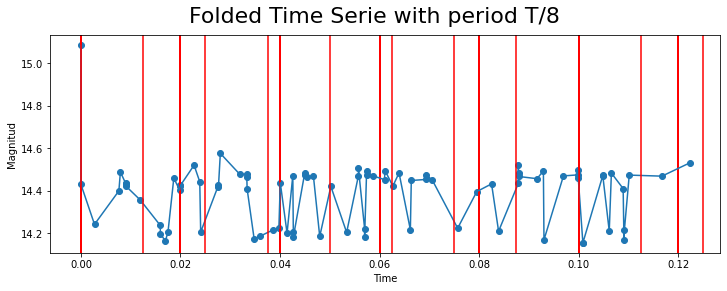

--------------------------------------------------
----------------------------------------------------------------------------------------------------
tiempo de ejecucion total: 5.561089800001355
promedio de tiempo de ejecucion por evento 1.11214182000258
----------------------------------------------------------------------------------------------------


In [109]:
# tiempo de ejecucion del algoritmo 
from numpy import NaN


start_analyze = default_timer()

all_tensor_ts = []
dict_tensor_all = {}

for index, event in enumerate(all_event):
  # inicio - tiempo de ejecucion del analisis de cada evento
  start_time_event = default_timer()
  print(f'n:{index} - oid:{event}')
  fig = go.Figure()

  # extrae todas las magnitudes asociadas al evento y las ordena por tiempo (mjd)
  light_curve = data.loc[data['oid'] == event].sort_values(by=['mjd'])

  # print(light_curve)
  # light_curve.head()

  # graficar serie de tiempo con link a sitio de ALeRCE
  for band in light_curve['fid'].unique():
    GraphicLightCurve(fig,band,light_curve,True)

  # tensor que reune todos los filtros
  tensor_all_filter = []
  dict_tensor = {}
  
  # nfid = numero del filter id (banda) = 1,green / 2,red
  for nfid in range(1,3):
    type_filter = lambda nfid: 'Green' if nfid == 1 else 'Red'
    # print('Filtro',nfid)
    idx_banda = (light_curve['fid'] == nfid)
    # aux = idx_banda.to_frame()
    
    # print(idx_banda)
    # print(len(idx_banda))

    mjd_min = light_curve.mjd.values.min()

    tiempoNormalizado = (light_curve.mjd.values - mjd_min) / (light_curve.mjd.values.max() - mjd_min)

    # print('a',array_periods)
    # print('b',tiempoNormalizado[idx_banda], type(tiempoNormalizado[idx_banda]))
    # print('c',light_curve.magpsf_corr[idx_banda].values,type(light_curve.magpsf_corr[idx_banda].values))

    if(len(tiempoNormalizado[idx_banda]) == 0 or np.isnan(tiempoNormalizado[idx_banda]).all()):
      # print('tiempoNormalizado is empty or nan')
      break

    if(len(light_curve.magpsf_corr[idx_banda].values)==0 or np.isnan(light_curve.magpsf_corr[idx_banda].values).all()):
      # print('magpsf of light curve is empty or nan')
      break

    # print('tiempoNormalizado\n',tiempoNormalizado)
    tensor = np.array(variantion_period_v2(array_periods, tiempoNormalizado[idx_banda], light_curve.magpsf_corr[idx_banda].values, nbines))
    tensor_all_filter.append(tensor)

    dict_tensor[f'Filter {type_filter(nfid)}'] = tensor_all_filter

    # print(f'dimensiones {tensor.shape}')
    # print(f'Tensor {index}: \n{tensor}')
    print('-'*50)



  dict_tensor_all[f'{event}'] = dict_tensor
  # asignar formato de tensor y muestralo
  tensor_all_filter = np.array(tensor_all_filter)
  # print(f'dimensiones total {tensor_all_filter.shape}')

  all_tensor_ts.append(tensor_all_filter)
  # print(f'Tensor total {index}: \n{tensor_all_filter}')

  # fin
  end_time_event = default_timer()

  # obtener el tiempo de ejecucion
  time_method_event = end_time_event - start_time_event
  # agrego el tiempo de ejecicion al arreglo para obtener el promedio general
  all_time_event.append(time_method_event)

  # print(f'tiempo de ejecucion por evento: {time_method_event}')
  # print('-'*100)

  if (index == limit - 1):
    break


end_analyze = default_timer()
time_method_analyze = end_analyze - start_analyze
print('-'*100)
print(f'tiempo de ejecucion total: {time_method_analyze}')
print(f'promedio de tiempo de ejecucion por evento',np.mean(all_time_event))
print('-'*100)

In [111]:
import json
from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)


all_tensor_ts = np.array(all_tensor_ts)
all_tensor_ts.shape

print(type(all_tensor_ts))
aux = {'group 0': all_tensor_ts}
test = json.dumps(dict_tensor_all, cls=NumpyArrayEncoder)
# print(test)

with open('group0.json', 'w') as outfile:
    outfile.write(test)


# print(all_tensor_ts)

# label_one = np.array(['one','two'])
# label_two = np.array(['a','b'])
# label_tree = np.array(['c','d'])
# label_four = np.array(['c','d'])
# label_five = np.array(['c','d'])


# cols = pd.MultiIndex.from_product([label_one,label_two,label_tree,label_four,label_five])


# all_tensor_df = pd.DataFrame(all_tensor_ts,columns=cols)
# all_tensor_df = pd.DataFrame(all_tensor_ts)

# np.savetxt('data.csv',all_tensor_ts,delimiter=';')


<class 'numpy.ndarray'>


In [51]:
decode_file = json.loads(test)

# print(decode_file)